# 2021-09-29 Handling stiffness

## Last time

* Stability for advection-diffusion
* Cost scaling

## Today

* Accuracy and stability barriers
* Runge-Kutta methods

In [1]:
using Plots
using LinearAlgebra
using SparseArrays
using Zygote

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function newton(residual, jacobian, u0; maxits=20)
    u = u0
    uhist = [copy(u)]
    normhist = []
    for k in 1:maxits
        f = residual(u)
        push!(normhist, norm(f))
        J = jacobian(u)
        delta_u = - J \ f
        u += delta_u
        push!(uhist, copy(u))
    end
    uhist, normhist
end

function plot_stability(Rz, title; xlims=(-6, 2), ylims=(-4, 4))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
end
Rz_theta(z, theta) = (1 + (1 - theta)*z) / (1 - theta*z)
plot_stability(z -> Rz_theta(z, .5), "Midpoint method")

function ode_theta_linear(A, u0; forcing=zero, tfinal=1, h=0.1, theta=.5)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        rhs = (I + h*(1-theta)*A) * u .+ h*forcing(t+h*theta)
        u = (I - h*theta*A) \ rhs
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

function advdiff_matrix(n; kappa=1, wind=1, upwind=0.)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i, i])
        append!(cols, wrap.(i-1:i+1))
        diffuse = [-1, 2, -1] * kappa / dx^2
        advect_upwind = [-1, 1, 0] * wind / dx
        advect_center = [-1, 0, 1] * wind / 2dx
        stencil = -diffuse - upwind * advect_upwind - (1 - upwind) * advect_center
        append!(vals, stencil)
    end
    sparse(rows, cols, vals)
end
advdiff_matrix(5, kappa=.1)

5×5 SparseMatrixCSC{Float64, Int64} with 15 stored entries:
 -1.25   -0.625    ⋅       ⋅      1.875
  1.875  -1.25   -0.625    ⋅       ⋅ 
   ⋅      1.875  -1.25   -0.625    ⋅ 
   ⋅       ⋅      1.875  -1.25   -0.625
 -0.625    ⋅       ⋅      1.875  -1.25

# Stiffness

> Stiff equations are problems for which explicit methods don't work. (Hairer and Wanner, 2002)

* "stiff" dates to Curtiss and Hirschfelder (1952)

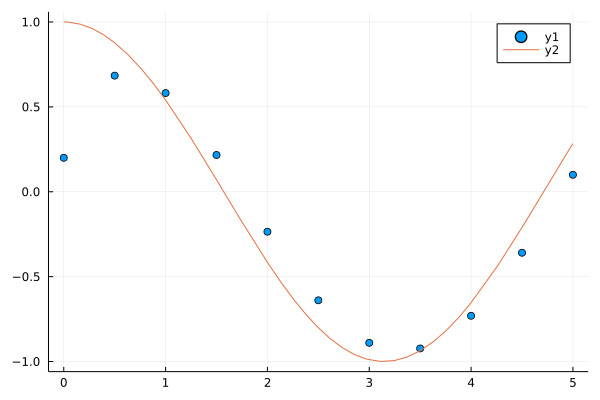

In [2]:
k = 5
thist, uhist = ode_theta_linear(-k, [.2], forcing=t -> k*cos(t), tfinal=5, h=.5, theta=1)
scatter(thist, uhist[1,:])
plot!(cos)

In [3]:
function mms_error(h; theta=.5, k=10)
    u0 = [.2]
    thist, uhist = ode_theta_linear(-k, u0, forcing=t -> k*cos(t), tfinal=3, h=h, theta=theta)
    T = thist[end]
    u_exact = (u0 .- k^2/(k^2+1)) * exp(-k*T) .+ k*(sin(T) + k*cos(T))/(k^2 + 1)
    uhist[1,end] .- u_exact
end

mms_error (generic function with 1 method)

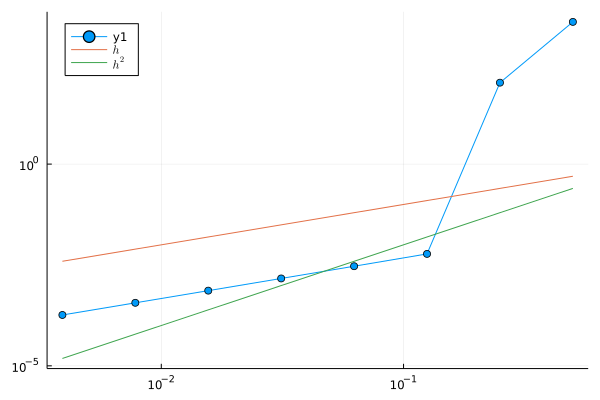

In [4]:
hs = .5 .^ (1:8)
errors = mms_error.(hs, theta=0, k=10)
plot(hs, norm.(errors), marker=:auto, xscale=:log10, yscale=:log10)
plot!(hs, hs, label="\$h\$", legend=:topleft)
plot!(hs, hs.^2, label="\$h^2\$")


## Discuss: is advection-diffusion stiff?

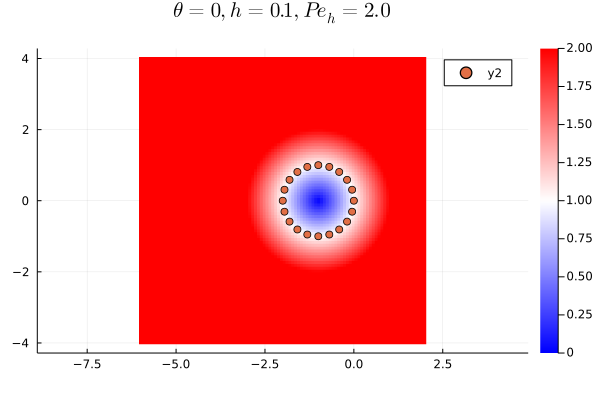

In [5]:
theta=0
n = 20
dx = 2 / n
kappa = .05
lambda_min = -4 * kappa / dx^2
cfl = 1
h = min(-2 / lambda_min, cfl * dx)

plot_stability(z -> Rz_theta(z, theta),
    "\$\\theta=$theta, h=$h, Pe_h = $(h/kappa)\$")
ev = eigvals(Matrix(h*advdiff_matrix(n, kappa=kappa, wind=1)))
scatter!(real(ev), imag(ev))

# Cost scaling

* Spatial discretization with error $O((\Delta x)^p)$
* Time discretization with error $O((\Delta t)^q)$

# Runge-Kutta methods

The methods we have considered thus far can all be expressed as Runge-Kutta methods, which are expressed in terms of $s$ "stage" equations (possibly coupled) and a completion formula.  For the ODE

$$ \dot u = f(t, u) $$

the Runge-Kutta method is

$$\begin{split}
Y_i = u(t) + h \sum_j a_{ij} f(t+c_j h, Y_j) \\
u(t+h) = u(t) + h \sum_j b_j f(t+c_j h, Y_j)
\end{split}$$
where $c$ is a vector of *abscissa*, $A$ is a table of coefficients, and $b$ is a vector of completion weights.

These coefficients are typically expressed in a Butcher Table
$$ \left[ \begin{array}{c|c} c & A \\ \hline & b^T \end{array} \right] = \left[ \begin{array}{c|cc}
c_0 & a_{00} & a_{01} \\
c_1 & a_{10} & a_{11} \\
\hline
& b_0 & b_1
\end{array} \right] . $$
We will see that, for consistency, the abscissa $c$ are always the row sums of $A$ and that $\sum_i b_i = 1$.

If the matrix $A$ is strictly lower triangular, then the method is **explicit** (does not require solving equations). 

# Past methods as Runge-Kutta

* Forward Euler
$$ \left[ \begin{array}{c|cc}
0 & 0 \\
\hline
& 1
\end{array} \right] ,$$
* Backward Euler
$$ \left[ \begin{array}{c|c}
1 & 1 \\
\hline
& 1
\end{array} \right] ,$$
* Midpoint
$$ \left[ \begin{array}{c|c}
\frac 1 2 & \frac 1 2 \\
\hline
& 1
\end{array} \right]. $$

Indeed, the $\theta$ method is
$$ \left[ \begin{array}{c|c}
\theta & \theta \\
\hline
& 1
\end{array} \right] $$
and an alternative "endpoint" variant of $\theta$ (a generalization of the trapezoid rule) is
$$ \left[ \begin{array}{c|cc}
0 & 0 & 0 \\
1 & 1-\theta & \theta \\
\hline
& 1-\theta & \theta
\end{array} \right]. $$

# Stability function for Runge-Kutta

To develop an algebraic expression for stability in terms of the Butcher Table, we consider the test equation

$$ \dot u = \lambda u $$

and apply the RK method to yield

$$ \begin{split} Y_i = u(0) + h \sum_j a_{ij} \lambda Y_j \\
u(h) = u(0) + h \sum_j b_j \lambda Y_j \end{split} $$

or, in matrix form,

$$ \begin{split} Y = \mathbb 1 u(0) + h \lambda A Y \\
u(h) = u(0) + h \lambda b^T Y \end{split} $$

where $\mathbb 1$ is a column vector of length $s$ consisting of all ones.
This reduces to
$$ u(h) = \underbrace{\Big( 1 + h\lambda b^T (I - h \lambda A)^{-1} \mathbb 1 \Big)}_{R(h\lambda)} u(0) . $$

# Plotting stability

$$ u(h) = \underbrace{\Big( 1 + h\lambda b^T (I - h \lambda A)^{-1} \mathbb 1 \Big)}_{R(h\lambda)} u(0) $$

In [11]:
struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

function rk_stability(z, rk)
    s = length(rk.b)
    1 + z * rk.b' * ((I - z*rk.A) \ ones(s))
end

rk_stability (generic function with 1 method)

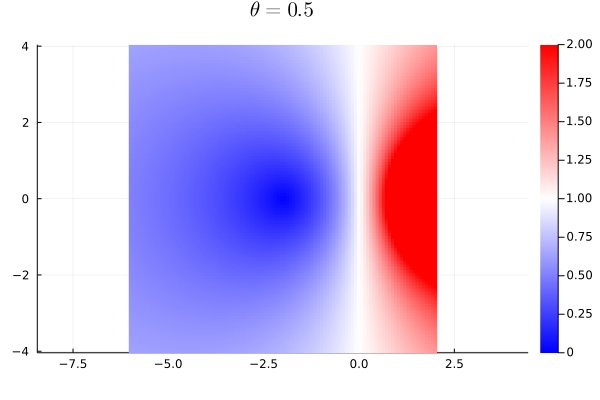

In [12]:
theta = .5
rk_theta(theta) = RKTable([theta], [1])
rk_theta_endpoint(theta) = RKTable([0 0;1-theta theta], [1-theta, theta])
table = rk_theta(theta)
plot_stability(z -> rk_stability(z, table), "\$\\theta = $theta\$")

# Heun's method and RK4

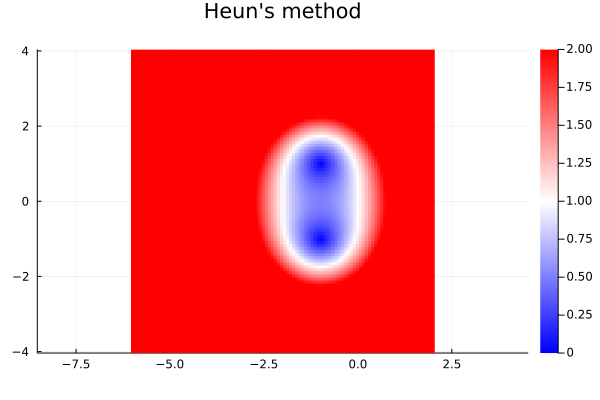

In [13]:
heun = RKTable([0 0; 1 0], [.5, .5])
plot_stability(z -> rk_stability(z, heun), "Heun's method")

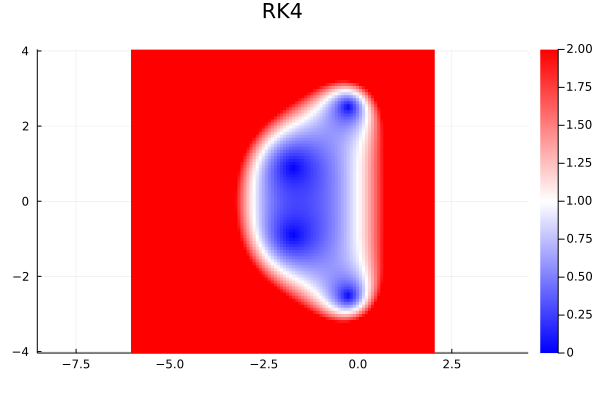

In [14]:
rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0],
[1, 2, 2, 1] / 6)
plot_stability(z -> rk_stability(z, rk4), "RK4")

# An explicit RK solver

\begin{align}
Y_i &= u(t) + h \sum_j a_{ij} f(t+c_j h, Y_j) &
u(t+h) &= u(t) + h \sum_j b_j f(t+c_j h, Y_j)
\end{align}

In [62]:
function ode_rk_explicit(f, u0; tfinal=1, h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk_explicit (generic function with 1 method)

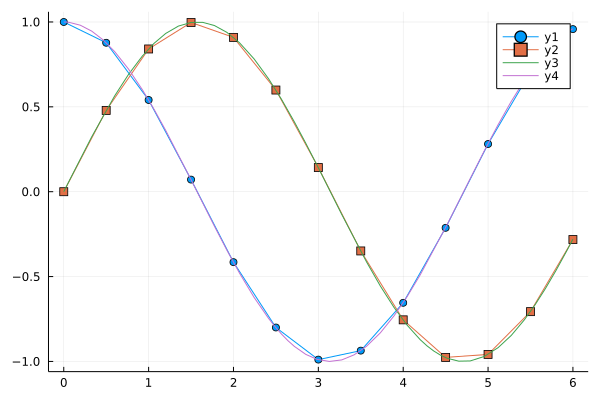

In [63]:
linear_oscillator(t, u) = [0 -1; 1 0] * u
thist, uhist = ode_rk_explicit(linear_oscillator, [1., 0], tfinal=6, h=.5)
plot(thist, uhist', marker=:auto)
plot!([sin, cos])

# Measuring convergence and accuracy

In [ ]:
function mms_error(h, f, u_exact; table=rk4)
    u0 = u_exact(0)
    thist, uhist = ode_rk_explicit(f, u0, tfinal=3, h=h, table=table)
    T = thist[end]
    uhist[:,end] - u_exact(T)
end

hs = .5 .^ (1:8)
linear_oscillator_exact(t) = [cos(t), sin(t)]

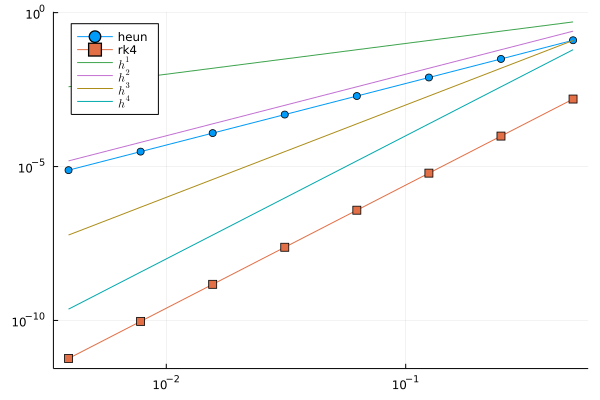

In [77]:
heun_errors = mms_error.(hs, linear_oscillator, linear_oscillator_exact, table=heun)
rk4_errors = mms_error.(hs, linear_oscillator, linear_oscillator_exact, table=rk4)
plot(hs, [norm.(heun_errors) norm.(rk4_errors)], label=["heun" "rk4"], marker=:auto)
plot!(hs, [hs hs.^2 hs.^3 hs.^4], label=["\$h^$p\$" for p in [1 2 3 4]], legend=:topleft, xscale=:log10, yscale=:log10)